# Treinamento do reconhecimento de portas com a VGG16

## Mostrando o Dataset

Para rodar tem que alterar os diretórios na enumeração Directory no arquivo utils:

```python

class Directory(Enum):
    train=("Treinamento", "/meu/diretorio/treinamento/")
    

```

E rodar a próxima cell

In [1]:
import utils

for item in utils.Directory:
    item.show_statistics()

Treinamento
961 files in Doors
219 files in Doors_Open
467 files in Stairs
113 files in Stairs_Top_View
1573 files in Indoor Environment


Validação
476 files in Doors
104 files in Doors_Open
192 files in Stairs
55 files in Stairs_Top_View
815 files in Indoor Environment


Testes
751 files in Doors
165 files in Doors_Open
298 files in Stairs
70 files in Stairs_Top_View
1167 files in Indoor Environment




**Se ficou certo** os dados de cada conjunto vão ser mostrados acima

# Extrair os Dados com a VGG19

O pacote tensorflow_vgg contém a VGG16 e a VGG19, para mais informações acessar o [repositório no Github](https://github.com/machrisaa/tensorflow-vgg).

É necessário ter os arquivos dos pesos do VGG16/19, que podem ser baixados nos links disponibilizados no repositório acima.

Depois rodar as próximas cell, para gerar os features de treinamento, validação, e testes a partir da VGG19.

In [ ]:
from tensorflow_vgg import vgg19

vgg = vgg19.Vgg19()
classes, directory = utils.Directory.train.classes, utils.Directory.train.dir
codes, labels = utils.generate_features(classes, directory, vgg)
utils.save_to_file("%s_vgg19" % utils.Directory.train.name, codes, labels)

/home/rodsnjr/Git/indoor_recognition/udacity_transfer_learning/tensorflow_vgg/vgg19.npy
npy file loaded
build model started
build model finished: 0s
Starting Doors images
OOM when allocating tensor of shape [25088,4096] and type float
	 [[Node: content_vgg/fc6/weights = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [25088,4096] values: [0.00074060471 -9.0235051e-05 0.00041919478]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'content_vgg/fc6/weights', defined at:
  File "/media/rodsnjr/Files/miniconda3/envs/indoor-recognition/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/media/rodsnjr/Files/miniconda3/envs/indoor-recognition/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/media/rodsnjr/Files/miniconda3/envs/indoor-recognition/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/rodsnjr/.local/lib/python3.5/si

In [7]:
vgg = vgg19.Vgg19()
classes, directory = utils.Directory.validation.classes, utils.Directory.validation.dir
codes, labels = utils.generate_features(classes, directory, vgg)
utils.save_to_file("%s_vgg19" % utils.Directory.validation.name, codes, labels)

/home/rodsnjr/Git/indoor_recognition/udacity_transfer_learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting Doors images
cannot reshape array of size 200704 into shape (1,224,224,3)
50 images processed
100 images processed
150 images processed
200 images processed
250 images processed
300 images processed
cannot reshape array of size 200704 into shape (1,224,224,3)
350 images processed
400 images processed
450 images processed
476 images processed
Starting Doors_Open images
50 images processed
100 images processed
104 images processed
Starting Stairs images
50 images processed
100 images processed
150 images processed
192 images processed
Starting Stairs_Top_View images
50 images processed
55 images processed
Starting Indoor Environment images
unsupported operand type(s) for /: 'MpoImageFile' and 'float'
cannot reshape array of size 200704 into shape (1,224,224,3)
50 images processed
100 images processed
cannot reshape array of size 200

In [8]:
vgg = vgg16.Vgg16()
classes, directory = utils.Directory.test.classes, utils.Directory.test.dir
codes, labels = utils.generate_features(classes, directory, vgg)
utils.save_to_file("%s_vgg19" % utils.Directory.test.name, codes, labels)

/home/rodsnjr/Git/indoor_recognition/udacity_transfer_learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting Doors images
50 images processed
cannot reshape array of size 200704 into shape (1,224,224,3)
100 images processed
150 images processed
200 images processed
250 images processed
300 images processed
350 images processed
400 images processed
450 images processed
cannot reshape array of size 200704 into shape (1,224,224,3)
500 images processed
550 images processed
600 images processed
650 images processed
cannot reshape array of size 200704 into shape (1,224,224,3)
700 images processed
750 images processed
751 images processed
Starting Doors_Open images
50 images processed
100 images processed
cannot reshape array of size 200704 into shape (1,224,224,3)
150 images processed
165 images processed
Starting Stairs images
50 images processed
100 images processed
150 images processed
200 images processed
250 images processed
298 images pr

# Checkpoint

## Treinamento da rede de Classificação

Depois de salvo os arquivos com as features tanto para treinamento, validação, e testes, têm-se a rede de classificação.

Primeiro se deve carregar os arquivos de features e labels de treinamento e validação:

In [1]:
from utils import Directory
from utils import get_data_labels, read_file

train_x, train_labels = read_file('%s_vgg' % Directory.train.name)
train_y, _ = get_data_labels(train_labels)

validation_x, validation_labels = read_file('%s_vgg' % Directory.validation.name)
validation_y, _ = get_data_labels(validation_labels)

print("Quantidade de dados de treinamento", train_x.shape[0])
print("Quantidade de dados de validação", validation_x.shape[0])

Quantidade de dados de treinamento 3319
Quantidade de dados de validação 1630


# Classifier

A rede é uma MLP com:
    1x256 FC connected network
    E um Softmax.

In [2]:
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

batch_size = 64

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

model = Sequential()
model.add(Dense(256, activation="relu", input_shape=[train_x.shape[1],]))
model.add(Dense(256, activation="relu"))
model.add(Dense(5, activation="softmax"))
model.compile(loss = "categorical_crossentropy", 
              optimizer = "adam", 
              metrics=["accuracy"])

model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=30,
          validation_data=(validation_x, validation_y),
        callbacks = [checkpoint, early])

Using TensorFlow backend.


Train on 3319 samples, validate on 1630 samples
Epoch 1/30
3319/3319 [==============================] - 6s - loss: 1.7597 - acc: 0.7041 - val_loss: 1.1102 - val_acc: 0.7613
Epoch 2/30
3319/3319 [==============================] - 0s - loss: 0.7198 - acc: 0.8039 - val_loss: 0.6765 - val_acc: 0.7209
Epoch 3/30
3319/3319 [==============================] - 0s - loss: 0.3312 - acc: 0.8716 - val_loss: 0.6907 - val_acc: 0.7466
Epoch 4/30
3319/3319 [==============================] - 0s - loss: 0.2001 - acc: 0.9274 - val_loss: 0.7734 - val_acc: 0.7626
Epoch 5/30
3319/3319 [==============================] - 0s - loss: 0.0965 - acc: 0.9699 - val_loss: 0.7275 - val_acc: 0.7828
Epoch 6/30
3319/3319 [==============================] - 0s - loss: 0.0552 - acc: 0.9855 - val_loss: 0.8761 - val_acc: 0.7742
Epoch 7/30
3319/3319 [==============================] - 0s - loss: 0.0279 - acc: 0.9949 - val_loss: 0.9565 - val_acc: 0.7816
Epoch 8/30
3319/3319 [==============================] - 0s - loss: 0.0113 - a

# Checkpoint 

### Testando

Depois de treinado é só rodar o método test do classifier.

Começamos carregando os dados de testes:

In [3]:
from utils import Directory
from utils import get_data_labels, read_file

test_x, test_labels = read_file('%s_vgg' % Directory.test.name)
test_y, lb = get_data_labels(test_labels)

print("Quantidade de dados de testes", test_x.shape[0])

Quantidade de dados de testes 2441


### Mostrando os resultados

O método test do classifier trará os resultados de acurácia.

In [4]:
from keras.models import load_model

model = load_model('vgg16_1.h5')
model.evaluate(test_x, test_y, batch_size=batch_size)

2048/2441 [========================>.....] - ETA: 0s

[0.94624860484011097, 0.80909463339582521]

### Predição

Uma predição básica para testar ...

/home/rodsnjr/Git/indoor_recognition/udacity_transfer_learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
INFO:tensorflow:Restoring parameters from checkpoints/vgg_16_clf.ckpt


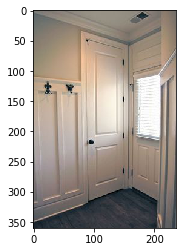

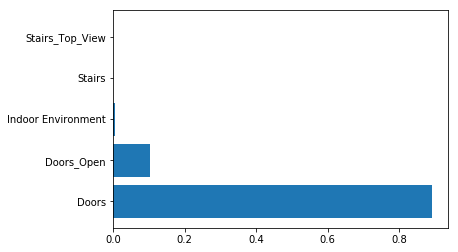

In [10]:
%matplotlib inline
from tensorflow_vgg import vgg16

# Tem que recarregar a VGG
vgg = vgg16.Vgg16()

test_img_path = '/media/rodsnjr/Files/Datasets/gvc_dataset_final/validation/Doors/0c162e13d912f66aabfb3cedb716cc5b.jpg'

clf.predict(vgg, test_img_path, lb)